In [9]:
import numpy as np
import pandas as pd

In [2]:
# download the dataset from Kaggle
!kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri -p ../Data

Dataset URL: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri
License(s): MIT
brain-tumor-classification-mri.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# unzip the dataset
!unzip ../Data/brain-tumor-classification-mri.zip -d ../Data

In [62]:
# loading and resizing images from training and testing directories while storing them with their corresponding labels
import os
import cv2 as cv

image_size = 224
labels = ['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor']

X, Y = [], []
for label in labels:
    training_path = os.path.join('/Data/Training', label)
    for filename in os.listdir(training_path):
        img = cv.imread(os.path.join(training_path, filename))
        img = cv.resize(img, (image_size, image_size))
        X.append(img)
        Y.append(label)

for label in labels:
    testing_path = os.path.join('/Data/Testing', label)
    for filename in os.listdir(testing_path):
        img = cv.imread(os.path.join(testing_path, filename))
        img = cv.resize(img, (image_size, image_size))
        X.append(img)
        Y.append(label)

X = np.array(X)
Y = np.array(Y)

In [63]:
# shuffling the dataset and splitting it into training and testing sets while maintaining the defined test size
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

X, Y = shuffle(X, Y)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

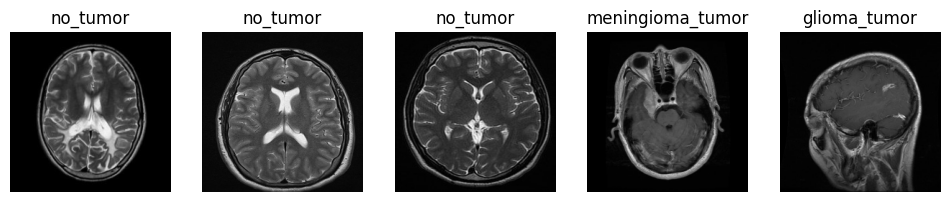

In [69]:
# selecting random images from the training set and displaying them with their labels
import matplotlib.pyplot as plt
import random

num_images = 5

indices = random.sample(range(len(X_train)), num_images)

plt.figure(figsize=(12, 6))
for i, idx in enumerate(indices):
    plt.subplot(1, num_images, i+1)
    plt.imshow(X_train[idx])
    plt.title(y_train[idx])
    plt.axis("off")

plt.show()

In [66]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (2611, 224, 224, 3)
y_train shape: (2611,)


In [70]:
# encoding class labels into numerical values and converting them into one-hot encoded format
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(labels))
y_test = tf.keras.utils.to_categorical(y_test, num_classes=len(labels))

In [71]:
# applying data augmentation techniques to the training images to enhance model generalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
datagen.fit(X_train)

In [73]:
# building a deep convolutional neural network with multiple convolutional blocks and regularization
from tensorflow.keras.regularizers import l2

model = tf.keras.models.Sequential()

# Block 1
model.add(tf.keras.layers.Input(shape=(224, 224, 3)))
model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Dropout(0.2))

# Block 2
model.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=l2(0.001)))
model.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu'))
model.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Dropout(0.3))

# Block 3
model.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=l2(0.001)))
model.add(tf.keras.layers.Conv2D(256, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Dropout(0.3))

# Block 4
model.add(tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_regularizer=l2(0.001)))
model.add(tf.keras.layers.Conv2D(256, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Dropout(0.4))

# Fully Connected Layers
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(4, activation='softmax'))


In [74]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 220, 220, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 110, 110, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 110, 110, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 108, 108, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 106, 106, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 104, 104, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 52, 52, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 52, 52, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 50, 50, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 48, 48, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 24, 24, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 24, 24, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 22, 22, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 20, 20, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │      13,107,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 15,121,092 (57.68 MB)

 Trainable params: 15,121,092 (57.68 MB)

 Non-trainable params: 0 (0.00 B)

In [77]:
# compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [78]:
# training the model
EPOCHS = 20
history = model.fit(X_train, y_train,
                    epochs = EPOCHS,
                    validation_split = 0.1)

Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 38s 388ms/step - accuracy: 0.3272 - loss: 23.2102 - val_accuracy: 0.4656 - val_loss: 2.6974
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 20s 273ms/step - accuracy: 0.5219 - loss: 2.5718 - val_accuracy: 0.6221 - val_loss: 2.2749
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 22s 289ms/step - accuracy: 0.5949 - loss: 2.3072 - val_accuracy: 0.5954 - val_loss: 2.2163
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 41s 287ms/step - accuracy: 0.6024 - loss: 2.1094 - val_accuracy: 0.6718 - val_loss: 2.0086
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 22s 301ms/step - accuracy: 0.6723 - loss: 1.9334 - val_accuracy: 0.6718 - val_loss: 1.8512
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 40s 285ms/step - accuracy: 0.7105 - loss: 1.7590 - val_accuracy: 0.7519 - val_loss: 1.6632
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 41s 291ms/step - accuracy: 0.7604 - loss: 1.5876 - val_accuracy: 0.7748 - val_loss: 1.6213
Epoch 8/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 41s 293ms/step - accuracy: 0.7774 - loss: 1.5011 - val_acc

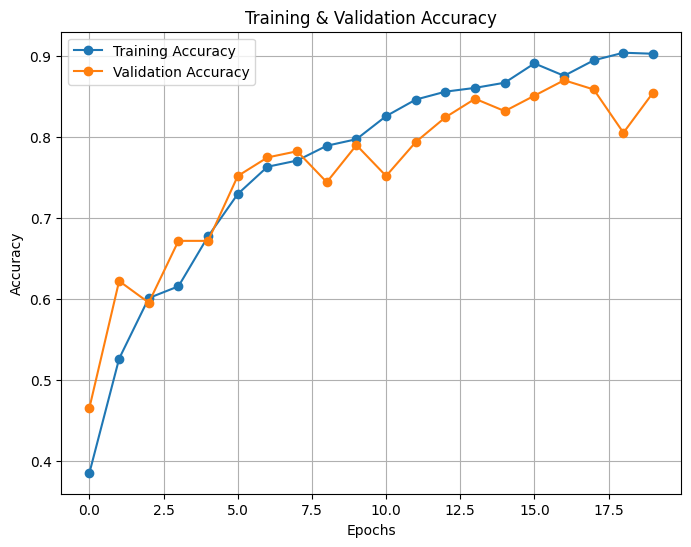

In [79]:
# plotting training and validation accuracy over epochs to visualize model performance

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 6))
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

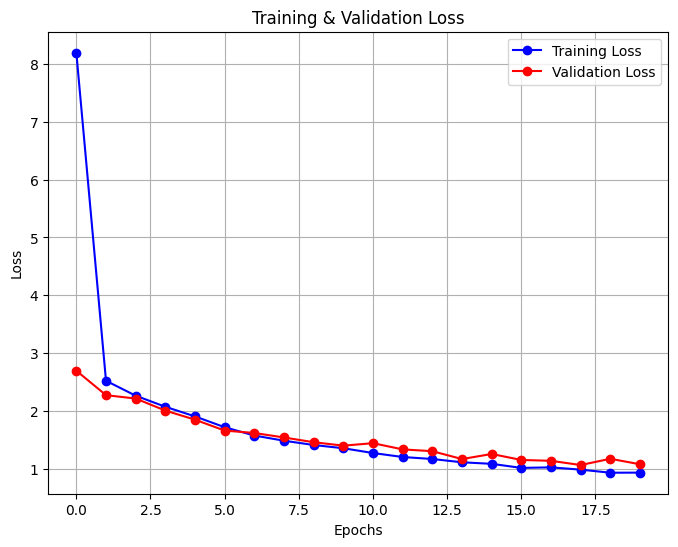

In [80]:
# plotting training and validation loss

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(8, 6))
plt.plot(epochs_range, loss, label='Training Loss', marker='o', color='blue')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step


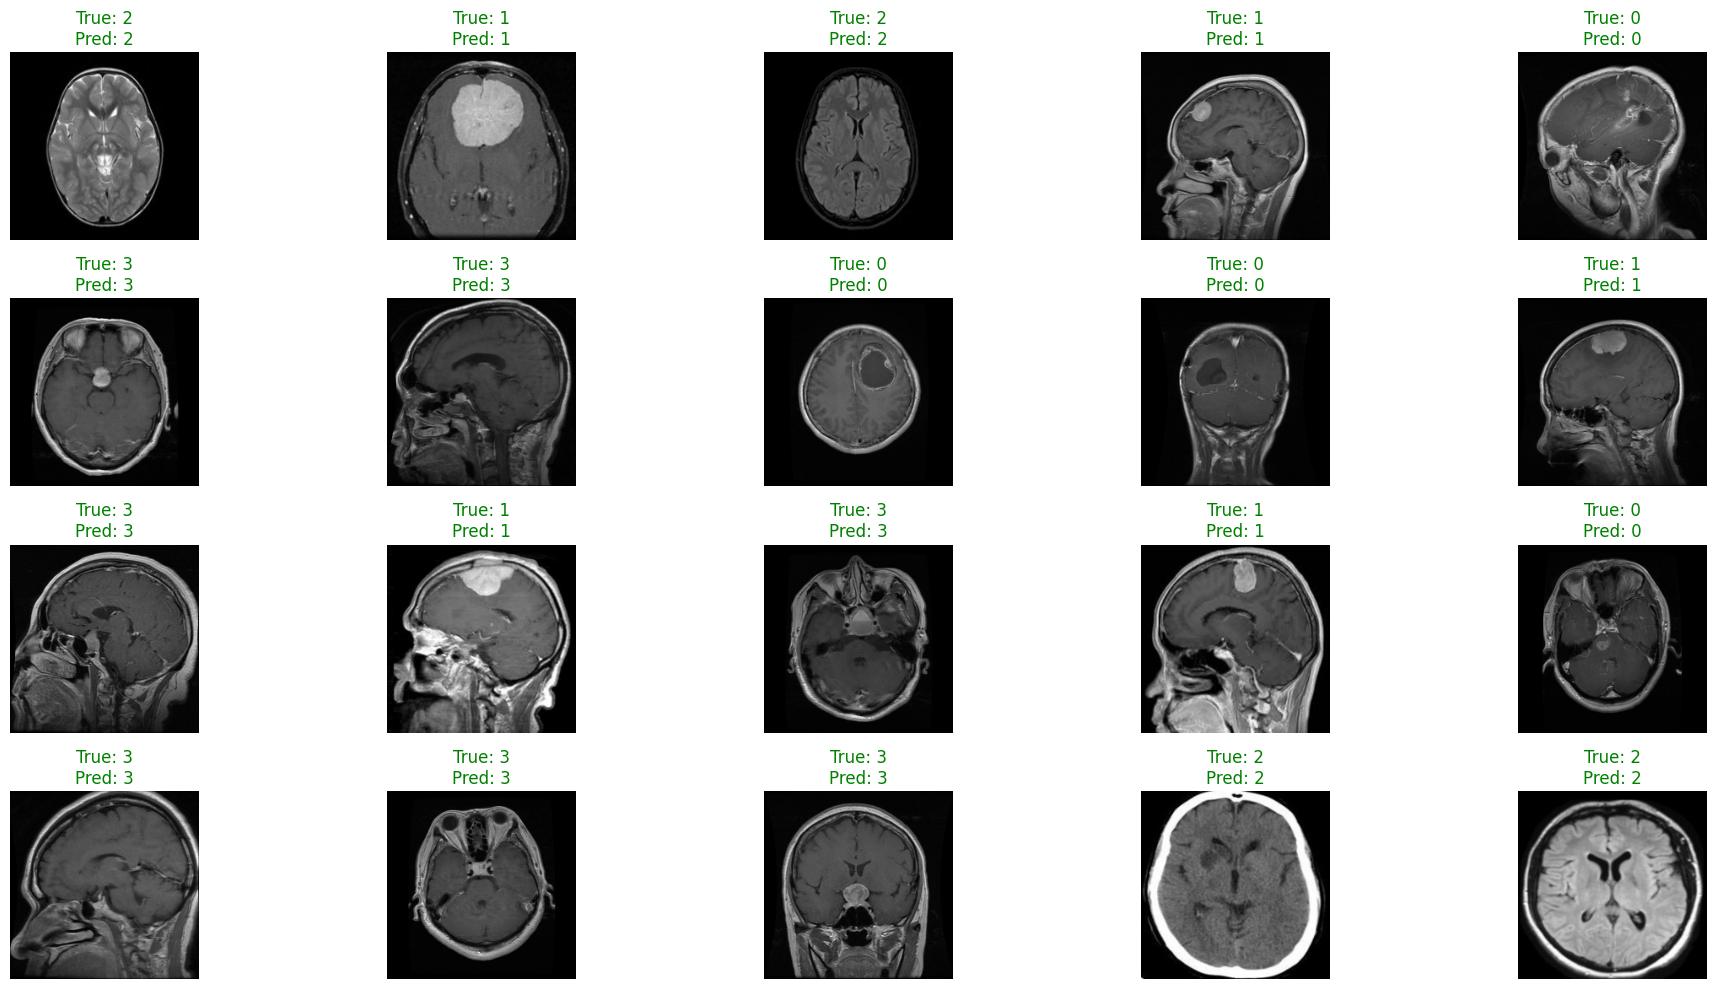

In [81]:
# visualizing model predictions by displaying random test images with true and predicted labels

y_test_pred = model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

random_indices = np.random.choice(len(X_test), 20, replace=False)

plt.figure(figsize=(20, 10))
for i, idx in enumerate(random_indices):
    img = X_test[idx]
    true_label = y_true[idx]
    pred_label = y_test_pred_classes[idx]

    plt.subplot(4, 5, i + 1)
    plt.imshow(img, cmap="gray")
    plt.axis("off")

    color = "green" if true_label == pred_label else "red"
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)

plt.tight_layout()
plt.show()

In [82]:
# evaluating the model
train_loss, train_acc = model.evaluate(X_train, y_train, verbose = 1)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose = 1)

print(f"Train Accuracy: {train_acc * 100:.2f}%")
print(f"Test Accuracy: {test_acc * 100:.2f}%")

82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.9675 - loss: 0.8321
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.8852 - loss: 1.0060
Train Accuracy: 95.37%
Test Accuracy: 88.21%
